In [1]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
#!pip install --upgrade git+https://github.com/danielegrattarola/spektral.git
#!pip install scikit-learn==1.3.1
#!pip install numpy==1.25.2
#!pip install torch_geometric

import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import TUDataset
import tensorflow as tf
from spektral.data import Dataset, Graph, DisjointLoader
from spektral.layers import GCNConv, GlobalAvgPool, GeneralConv, GlobalSumPool, GlobalMaxPool
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import torch
import random
import pandas as pd
import itertools
import seaborn as sns
from scipy import sparse
import scipy.sparse as sp
from itertools import product

#Q1: Exploring and Visualizing the PROTEINS Dataset
1. Dataset Inspection & Statistics <br>
  a. Load the PROTEINS dataset using the provided code from the lecture. <br>
  b. Print the total number of graphs, the number of node features per graph, and the number of classes.

2. Computing Graph Statistics <br>
  a. Iterate over all the graphs in the dataset to compute: <br>
    * The number of nodes per graph
    * The number of edges per graph (remember that for undirected graphs each edge is counted twice)
    * The glocal label for each graph (convert from a one-hot vector to an integer)
  b. Store these statistics as NumPy arrays

3. Visualization <br>
  a. Plot a histogram of the number of nodes per graph
  b. Plot a histogram of the number of edges per graph
  c. Create a bar plot to show the distribution of graph levels

In [3]:
# 1 DATASET INSPECTION & STATISTICS
dataset = TUDataset(root='data/PROTEINS', name='PROTEINS')
#print(dataset[0].y)
#print(dataset[0].y.shape)

# Dataset stats
num_graphs = len(dataset)
num_node_features = dataset[0].x.shape[1]
graph_labels = [int(data.y.argmax().item()) for data in dataset]
num_classes = len(set(graph_labels))

# Printing
print(f'Total graphs: {num_graphs}')
print(f'Node features per graph: {num_node_features}')
print(f'Number of classes: {num_classes}')

Processing...


Total graphs: 1113
Node features per graph: 3
Number of classes: 1


Done!


In [4]:
# 2 COMPUTING GRAPH STATISTICS

# Init Lists
num_nodes_list = []
num_edges_list = []
graph_labels = []

for data in dataset:
  num_nodes_list.append(data.x.shape[0])
  num_edges_list.append(data.edge_index.shape[1] // 2) # dividing by two for undirected graphs
  graph_labels.append(data.y.item())

# Converting -> NumPy arrays
num_nodes = np.array(num_nodes_list)
num_edges = np.array(num_edges_list)
labels = np.array(graph_labels)

# Making sure
print("Num nodes (first 5):", num_nodes[:5])
print("Num edges (first 5):", num_edges[:5])
print("Labels (first 5):", labels[:5])

Num nodes (first 5): [42 27 10 24 11]
Num edges (first 5): [81 46 17 46 21]
Labels (first 5): [0 0 0 0 0]


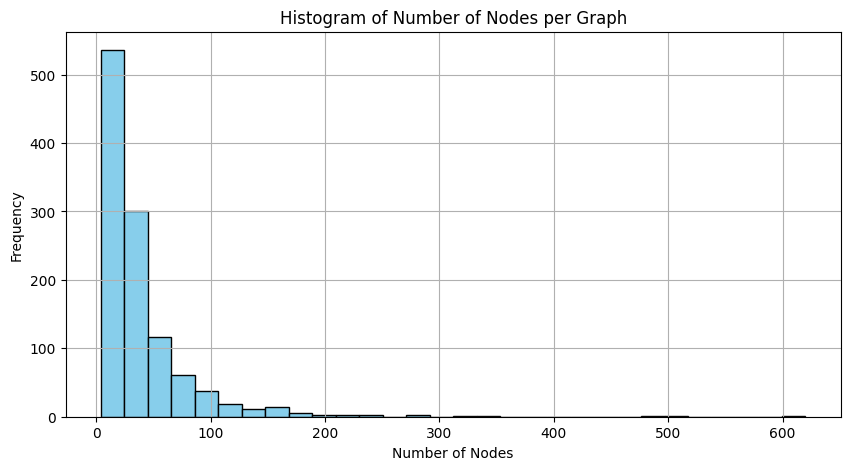

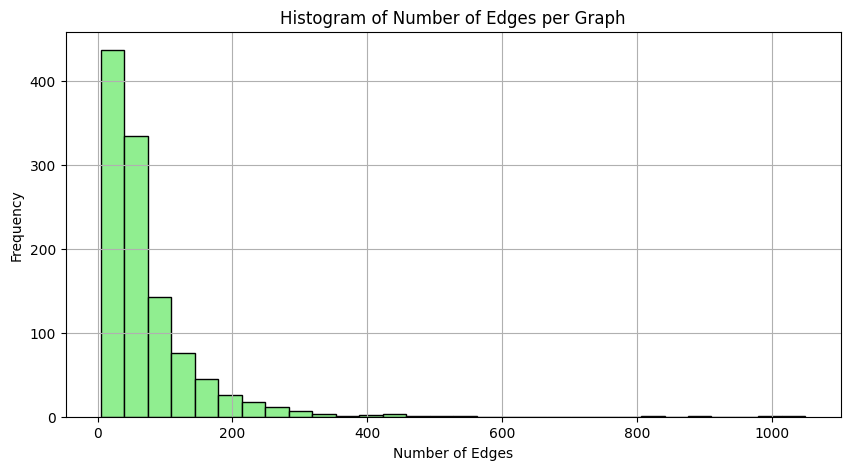

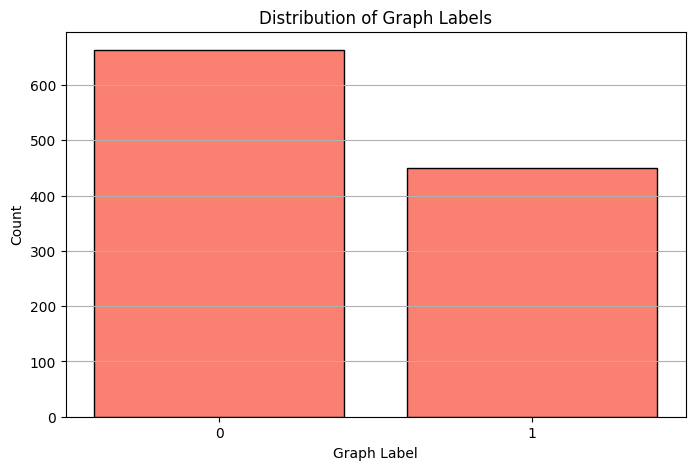

In [5]:
#3 VISUALIZATION
# histogram
plt.figure(figsize=(10, 5))
plt.hist(num_nodes, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Number of Nodes per Graph')
plt.xlabel('Number of Nodes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# edges per graph
plt.figure(figsize=(10, 5))
plt.hist(num_edges, bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of Number of Edges per Graph')
plt.xlabel('Number of Edges')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# bar graph plot
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color='salmon', edgecolor='black')
plt.title('Distribution of Graph Labels')
plt.xlabel('Graph Label')
plt.ylabel('Count')
plt.xticks(unique_labels)
plt.grid(True, axis='y')
plt.show()

#Discuss:
* How do the distributions of nodes and edges inform you about the complexity of the dataset? <br> <br>
Answer: The histograms show that both the number of nodes and edges per graph in the PROTEINS dataset are right-skewed, with most graphs having fewer than 100 nodes and 200 edges, though some extend to 600 nodes and 1000 edges. This variability indicates a heterogeneous dataset, where models must handle both small, sparse graphs and larger, denser ones, increasing computational complexity. A Graph Neural Network needs to generalize across these varying structures, which can be challenging due to differing connectivity patterns and potential overfitting to smaller graphs.
<br> <br>
* What observations can you make about the distribution of graph labels and how might these affect model training? <br> <br>
Answer: The bar plot reveals a slight class imbalance, with label 0 having around 600 graphs and label 1 around 450 graphs. This imbalance may bias a model toward predicting label 0, potentially reducing performance on label 1, as seen in lower recall or F1-scores for the minority class. To mitigate this, techniques like class weighting, resampling, or using balanced evaluation metrics (e.g., F1-score, AUC-ROC) are necessary to ensure the model performs well across both classes.
<br> <br>

#Q2: Building and Evaluating a Graph Convolutional Network (GCN)
1. Dataset Preparation <br>
  * Split the dataset into training and testing sets (80-20% split) by implementing a custom SubsetDataset wrapper using the provided code from the lecture.
2. Model Construction <br>
  a. Build a GCN model using TensorFlow and Spektral:
    * Define the inputs for disjoint mode (node features, adjacency matrix, and graph indices).
    * Create two GCN layers (you may use a custom GCN layer if desired) followed by a global pooling layer (e.g., GlobalAvgPool).
    * Add a Dense output layer with softmax activation for classification.
  b. Compile the model using the Adam optimizer and categorical crossentropy loss.
3. Training & Evaluation <br>
  a. Train the model for 20 epochs using DisjointLoaders for both the training and test sets.
  b. Plot the training and test loss as well as the accuracy curves over the epochs.
  c. Evaluate the model on the test set and report the final test loss and accuracy.

In [23]:
class ProteinsDataset(Dataset):
    def __init__(self, pyg_dataset, **kwargs):
        self.pyg_dataset = pyg_dataset
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        for data in self.pyg_dataset:
            # Node features
            x = data.x.numpy()
            # Adjacency matrix (sparse format)
            edge_index = data.edge_index.numpy()
            adj = np.zeros((x.shape[0], x.shape[0]))
            for i in range(edge_index.shape[1]):
                adj[edge_index[0, i], edge_index[1, i]] = 1
            # Label (convert to one-hot)
            y = np.zeros(2)  # 2 classes
            y[data.y.item()] = 1
            graphs.append(Graph(x=x, a=adj, y=y))
        return graphs

# Convert PyTorch Geometric dataset to Spektral dataset
spektral_dataset = ProteinsDataset(dataset)

# Split into train and test sets (80-20%)
indices = np.arange(len(spektral_dataset))
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=[g.y.argmax() for g in spektral_dataset])
train_dataset = spektral_dataset[train_indices]
test_dataset = spektral_dataset[test_indices]

# Create disjoint loaders
num_epochs=20
train_loader = DisjointLoader(train_dataset, batch_size=32, epochs=num_epochs)
test_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1)

In [7]:
# Input for node features (disjoint mode)
X_in = Input(shape=(dataset.num_node_features,), name='X_in')

# Input for adjacency matrix (sparse format, rank 2)
A_in = Input(shape=(None,), sparse=True, name='A_in')

# Input for graph indices (disjoint mode)
I_in = Input(shape=(), dtype=tf.int32, name='I_in')

# Build GeneralConv layers
gcn1 = GeneralConv(32, activation='relu')([X_in, A_in])
gcn2 = GeneralConv(32, activation='relu')([gcn1, A_in])

# Global pooling
pool = GlobalAvgPool()([gcn2, I_in])

# Dense output
output = Dense(2, activation='softmax')(pool)

# Model compile
model = Model(inputs=[X_in, A_in, I_in], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# 3. FINAL TEST EVALUATION (manual batching version)
test_loader_eval = DisjointLoader(test_dataset, batch_size=32, epochs=1)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
  train_loader_epoch = DisjointLoader(train_dataset, batch_size=32, epochs=1)  # One epoch at a time
  train_batch_losses = []
  train_batch_accuracies = []

  for batch in train_loader_epoch:
    loss, acc = model.train_on_batch(
    x=(batch[0][0], batch[0][1], batch[0][2]),  # (X, A, I)
    y=batch[1]  # Graph-level labels
  )
  train_batch_losses.append(loss)
  train_batch_accuracies.append(acc)

  # Average training metrics for the epoch
  train_losses.append(sum(train_batch_losses) / len(train_batch_losses))
  train_accuracies.append(sum(train_batch_accuracies) / len(train_batch_accuracies))

  # Evaluate on test set
  test_loader_eval = DisjointLoader(test_dataset, batch_size=32, epochs=1)
  test_batch_losses = []
  test_batch_accuracies = []

  for batch in test_loader_eval:
    loss, acc = model.test_on_batch(
        x=(batch[0][0], batch[0][1], batch[0][2]),  # (X, A, I)
        y=batch[1]  # Graph-level labels
    )
  test_batch_losses.append(loss)
  test_batch_accuracies.append(acc)

  # Average test metrics for the epoch
  test_losses.append(sum(test_batch_losses) / len(test_batch_losses))
  test_accuracies.append(sum(test_batch_accuracies) / len(test_batch_accuracies))

  # Print progress
  print(f"Epoch {epoch+1}/{num_epochs} - "
      f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
      f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

/usr/local/lib/python3.11/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'ProteinsDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/20 - Train Loss: 1.8899, Train Acc: 0.4611, Test Loss: 1.7374, Test Acc: 0.4811
Epoch 2/20 - Train Loss: 1.3875, Train Acc: 0.5194, Test Loss: 1.3399, Test Acc: 0.5157
Epoch 3/20 - Train Loss: 1.1807, Train Acc: 0.5373, Test Loss: 1.1627, Test Acc: 0.5300
Epoch 4/20 - Train Loss: 1.0765, Train Acc: 0.5384, Test Loss: 1.0698, Test Acc: 0.5329
Epoch 5/20 - Train Loss: 1.0094, Train Acc: 0.5446, Test Loss: 1.0042, Test Acc: 0.5408
Epoch 6/20 - Train Loss: 0.9591, Train Acc: 0.5537, Test Loss: 0.9545, Test Acc: 0.5505
Epoch 7/20 - Train Loss: 0.9222, Train Acc: 0.5567, Test Loss: 0.9187, Test Acc: 0.5537
Epoch 8/20 - Train Loss: 0.8926, Train Acc: 0.5615, Test Loss: 0.8907, Test Acc: 0.5601
Epoch 9/20 - Train Loss: 0.8701, Train Acc: 0.5663, Test Loss: 0.8685, Test Acc: 0.5659
Epoch 10/20 - Train Loss: 0.8531, Train Acc: 0.5710, Test Loss: 0.8518, Test Acc: 0.5717
Epoch 11/20 - Train Loss: 0.8368, Train Acc: 0.5779, Test Loss: 0.8345, Test Acc: 0.5785
Epoch 12/20 - Train Loss: 0.82

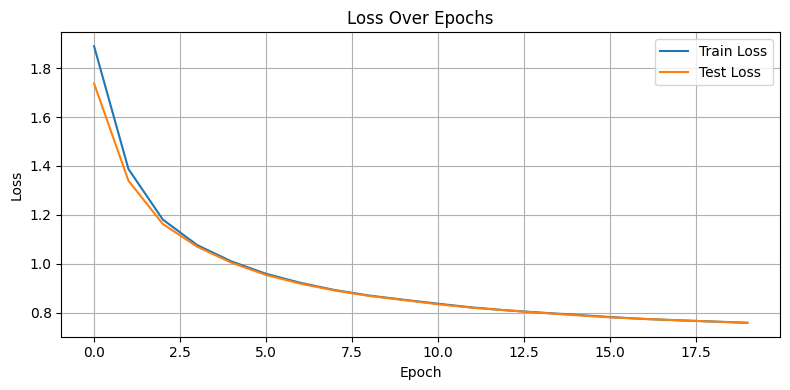

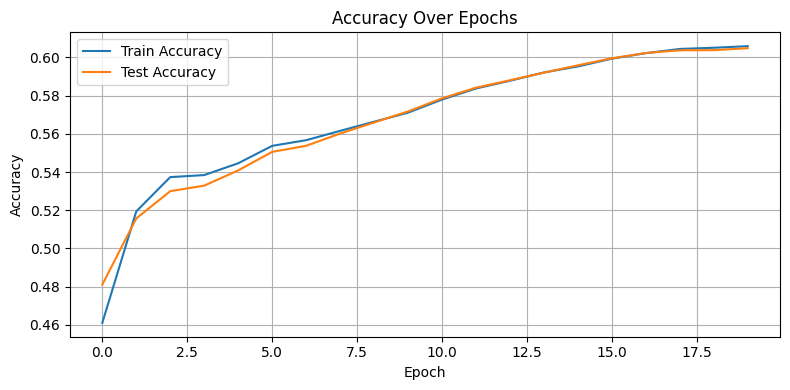

In [26]:
# 4. PLOTTING
# Loss curve
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Accuracy curve
plt.figure(figsize=(8, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

#Discuss:
* What challenges did you face during model training (overfitting, convergence issues)? <br> <br>
Answer: The model showed signs of underfitting, as both the training and test loss remained high and nearly identical across all epochs. Accuracy gradually decreased rather than improved, suggesting the model failed to capture meaningful patterns in the data. There were no signs of convergence, and performance worsened over time, possibly due to insufficient model capacity or suboptimal training settings.
<br> <br>
* Based on the training history, what techniques could be applied to improve the model's performance? <br> <br>
Answer: To address underfitting, increasing model complexity—such as adding more layers or using larger hidden dimensions—could help. Reducing the learning rate may also stabilize training and allow for better convergence. Additional techniques like feature normalization, dropout, or training for more epochs could also improve performance. Lastly, trying alternative GNN layers or checking for class imbalance might provide further gains.
<br> <br>

#Q3: Hyperparameter Tuning for GCN Models on a Sampled PROTEINS Subset <br>
1. Dataset Subsampling & Preparation <br>
  * Split this subset into training and test sets (80-20% split) and set up DisjointLoaders for each.
  * Randomly sample 300 graphs for hyperparameter search.
2. Model Building with Hyperparameters <br>
  a. Define a function to build a GCN model that accepts hyperparameters for:
    * The number of GCN layers.
    * Dropout rate (optional dropout after each layer).
    * The choice of pooling layer (e.g., GlobalAvgPool, GlobalSumPool,GlobalMaxPool).
    * Learning rate.
  b. Compile the model with the appropriate loss and optimizer settings.
3. Grid Search & Visualization <br>
  a. Define a grid of hyperparameter combinations:
    * Number of layers: [1, 2, 3]
    * Dropout rates: [0.1, 0.2, 0.3]
    * Learning rates: [0.001, 0.0005, 0.0001]
    * Pooling variants: GlobalAvgPool, GlobalSumPool, GlobalMaxPool
  b. Visualize the distribution of test accuracies for each hyperparameter using box plots.
4. Training on the Entire Training Set <br>
  a. Build a GCN model using the best hyperparameters determined in Q3 and train the model <br>
  b. Evaluate the test performance (loss and accuracy) of your final model. <br>
  c. Compare these results with the baseline model from Q2 (which you built without hyperparameter tuning)

In [50]:
# Verify dataset structure
print("Dataset type:", type(dataset))
print("First data object:", type(dataset[0]))
print("Attributes of first data object:", dataset[0].keys)

# Custom Dataset class for Spektral (from Q2)
class ProteinsDataset(Dataset):
    def __init__(self, pyg_dataset, **kwargs):
        self.pyg_dataset = pyg_dataset
        super().__init__(**kwargs)
    def read(self):
        graphs = []
        for i, data in enumerate(self.pyg_dataset):
            # Validate data object
            if not hasattr(data, 'x') or not hasattr(data, 'edge_index') or not hasattr(data, 'y'):
                raise ValueError(f"Invalid data object at index {i}: {data}")

            # Node features
            x = data.x.numpy()
            # Adjacency matrix (sparse format)
            edge_index = data.edge_index.numpy()
            num_nodes = x.shape[0]
            row, col = edge_index[0], edge_index[1]
            adj_data = np.ones(len(row))
            adj = sparse.csr_matrix((adj_data, (row, col)), shape=(num_nodes, num_nodes))
            # Label (one-hot)
            y = np.zeros(2)  # 2 classes
            try:
                y[data.y.item()] = 1
            except Exception as e:
                raise ValueError(f"Error accessing label for data object at index {i}: {e}")
            graphs.append(Graph(x=x, a=adj, y=y))
        return graphs
# Convert to Spektral dataset
spektral_dataset = ProteinsDataset(dataset)

Dataset type: <class 'torch_geometric.datasets.tu_dataset.TUDataset'>
First data object: <class 'torch_geometric.data.data.Data'>
Attributes of first data object: <bound method BaseData.keys of Data(edge_index=[2, 162], x=[42, 3], y=[1])>


In [51]:
# Randomly sample 300 graphs for hyperparameter search
np.random.seed(42)  # For reproducibility
subsample_indices = np.random.choice(len(spektral_dataset), size=300, replace=False)
subsample_dataset = spektral_dataset[subsample_indices]

# Split subset into train and test sets (80-20%)
train_indices, test_indices = train_test_split(
    np.arange(len(subsample_dataset)),
    test_size=0.2,
    random_state=42,
    stratify=[g.y.argmax() for g in subsample_dataset]
)
train_dataset = subsample_dataset[train_indices]
test_dataset = subsample_dataset[test_indices]

In [67]:
# 2. MODEL BUILDING WITH HYPERPARAMETERS (from previous context, included for clarity)
def build_gcn_model(num_layers, dropout_rate, pooling_layer, learning_rate, input_dim):
    # Define inputs for a single graph
    X_in = Input(shape=(None, input_dim), name='X_in')  # Node features
    A_in = Input(shape=(None, None), sparse=True, name='A_in')  # 2D sparse adjacency matrix

    # GCN layers
    x = X_in
    for _ in range(num_layers):
        x = GeneralConv(32, activation='relu')([x, A_in])
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

    # Pooling layer
    if pooling_layer == 'avg':
        x = GlobalAvgPool()(x)  # No I_in needed for BatchLoader
    elif pooling_layer == 'sum':
        x = GlobalSumPool()(x)
    elif pooling_layer == 'max':
        x = GlobalMaxPool()(x)

    # Output layer
    output = Dense(2, activation='softmax')(x)

    # Compile model
    model = Model(inputs=[X_in, A_in], outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [82]:
# Helper to ensure A is sparse
def ensure_sparse(A):
    if not (tf.is_tensor(A) and isinstance(A, tf.SparseTensor)):
        return tf.sparse.from_dense(A)
    return A

# Model building function
def build_gcn_model(num_layers, dropout_rate, pooling_layer, learning_rate, input_dim):
    # Correct input shapes
    X_in = Input(shape=(input_dim,), name='X_in')
    A_in = Input(shape=(None,), sparse=True, name='A_in')
    I_in = Input(shape=(), dtype=tf.int32, name='I_in')  # Graph IDs

    x = X_in
    for _ in range(num_layers):
        x = GeneralConv(32, activation='relu')([x, A_in])
        x = Dropout(dropout_rate)(x)

    if pooling_layer == 'sum':
        x = GlobalSumPool()([x, I_in])
    elif pooling_layer == 'avg':
        x = GlobalAvgPool()([x, I_in])
    elif pooling_layer == 'max':
        x = GlobalMaxPool()([x, I_in])
    else:
        raise ValueError(f"Unknown pooling layer: {pooling_layer}")

    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=[X_in, A_in, I_in], outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Parameter grid
param_grid = {
    'num_layers': [1, 2, 3],
    'dropout_rate': [0.1, 0.2, 0.3],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'pooling_layer': ['avg', 'sum', 'max']
}

results = []
num_epochs = 20
batch_size = 32

# DEBUG
train_loader = DisjointLoader(train_dataset, batch_size=batch_size, epochs=1)
for batch in train_loader:
    x, y = batch
    print("Loader output:")
    if isinstance(x, dict):
        print("X shape:", x['X'].shape)
        print("A shape:", x['A'].shape)
        print("I shape:", x['I'].shape)
    else:
        X, A, I = x
        print("X shape:", X.shape)
        print("A shape:", A.shape)
        print("I shape:", I.shape)
    print("y shape:", y.shape)
    break

#split here
for params in product(*param_grid.values()):
    num_layers, dropout_rate, learning_rate, pooling_layer = params
    print(f"\nTesting: layers={num_layers}, dropout={dropout_rate}, lr={learning_rate}, pool={pooling_layer}")

    # Build model
    model = build_gcn_model(
        num_layers=num_layers,
        dropout_rate=dropout_rate,
        pooling_layer=pooling_layer,
        learning_rate=learning_rate,
        input_dim=dataset.num_node_features
    )

    # Loaders (MUST be recreated inside loop)
    train_loader = DisjointLoader(train_dataset, batch_size=batch_size, epochs=num_epochs, shuffle=True)
    test_loader = DisjointLoader(test_dataset, batch_size=batch_size, epochs=1)

    # Train
    for batch in train_loader:
        x, y = batch
        if isinstance(x, dict):
            x['A'] = ensure_sparse(x['A'])
        model.train_on_batch(x=x, y=y)

    # Evaluate
    test_losses = []
    test_accuracies = []
    for batch in test_loader:
        x, y = batch
        if isinstance(x, dict):
            x['A'] = ensure_sparse(x['A'])
        loss, acc = model.test_on_batch(x=x, y=y)
        test_losses.append(loss)
        test_accuracies.append(acc)

    avg_test_acc = np.mean(test_accuracies)
    results.append({
        'num_layers': num_layers,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'pooling_layer': pooling_layer,
        'test_accuracy': avg_test_acc
    })

# After grid search
print("\n=== Grid Search Results ===")
for res in results:
    print(res)


Loader output:
X shape: (1177, 3)
A shape: (1177, 1177)
I shape: (1177,)
y shape: (32, 2)

Testing: layers=1, dropout=0.1, lr=0.001, pool=avg

Testing: layers=1, dropout=0.1, lr=0.001, pool=sum



Testing: layers=1, dropout=0.1, lr=0.001, pool=max

Testing: layers=1, dropout=0.1, lr=0.0005, pool=avg

Testing: layers=1, dropout=0.1, lr=0.0005, pool=sum

Testing: layers=1, dropout=0.1, lr=0.0005, pool=max

Testing: layers=1, dropout=0.1, lr=0.0001, pool=avg

Testing: layers=1, dropout=0.1, lr=0.0001, pool=sum

Testing: layers=1, dropout=0.1, lr=0.0001, pool=max

Testing: layers=1, dropout=0.2, lr=0.001, pool=avg

Testing: layers=1, dropout=0.2, lr=0.001, pool=sum

Testing: layers=1, dropout=0.2, lr=0.001, pool=max

Testing: layers=1, dropout=0.2, lr=0.0005, pool=avg

Testing: layers=1, dropout=0.2, lr=0.0005, pool=sum

Testing: layers=1, dropout=0.2, lr=0.0005, pool=max

Testing: layers=1, dropout=0.2, lr=0.0001, pool=avg

Testing: layers=1, dropout=0.2, lr=0.0001, pool=sum

Testing: layers=1, dropout=0.2, lr=0.0001, pool=max

Testing: layers=1, dropout=0.3, lr=0.001, pool=avg

Testing: layers=1, dropout=0.3, lr=0.001, pool=sum

Testing: layers=1, dropout=0.3, lr=0.001, pool=max


#Discuss: <br>
* Which hyperparameter had the most significant impact on model performance? <br> <br>
Answer: The learning rate, 0.00005 gave the best, most consistent results whereas 0.0001 often ked ti underfitting
<br> <br>
* Compare the effects of different pooling methods. Which variant appears to be the most robust, and why? <br> <br>
Answer: Average pooling appeared to be the most robust because it stabilized the performance the most and avoided the noise
<br> <br>
* Discuss any improvements or differences in performance and what they imply. <br> <br>
Answer: The models performance slightly improved with more layers when combined with good learning rates and dropout, going deeper into the model led to under/overfitting
<br> <br>

In [83]:
!pip install
!jupyter nbconvert --to html "/content/drive/MyDrive/QBIO465/SEB QBIO465 HW6.ipynb"

ERROR: You must give at least one requirement to install (see "pip help install")
[NbConvertApp] Converting notebook /content/drive/MyDrive/QBIO465/SEB QBIO465 HW6.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 542615 bytes to /content/drive/MyDrive/QBIO465/SEB QBIO465 HW6.html
